In [158]:
import time
import sys
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import datetime
import requests_cache
import numpy as np

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

# from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
# import scipy.stats as sp
from scipy.stats import skew, kurtosis, shapiro
# from utils import *
import matplotlib.pyplot as plt
# import math

%matplotlib inline

import statsmodels.formula.api as smf
sys.path.append('../')
from backtrader_app.backtest import run_backtest

import statsmodels.api as sm

In [187]:

current_date = datetime.datetime.now()
current_date_formatted = current_date.strftime("%Y-%m-%d")
first_day_of_year = datetime.datetime(
    current_date.year, 1, 1)
first_day_of_year_formatted = datetime.datetime(
    current_date.year, 1, 1).strftime("%Y-%m-%d")

def custom_monthly_return(resampled_data):

    # print(resampled_data.head(1)['total'].value)
    # Calculate the monthly return based on the specified formula
    first_day_return = resampled_data['total'].iloc[0]
    last_day_return = resampled_data['total'].iloc[-1]
    
    if pd.notna(first_day_return) and pd.notna(last_day_return) and first_day_return != 0:
        monthly_return = (last_day_return - first_day_return) / first_day_return
        # print(monthly_return)
        return monthly_return
    else:
        return pd.NA
    
class Stock:
    def __init__(self, ticker, df=None, initial_capital=1000, path=r"/Users/lucasmoyer/development/two-dolla/stocks.pkl", save_new=False, debug=False):
        self.ticker = ticker
        self.initial_capital = initial_capital
        self.isBankrupt = 0
        self.path = path
        self.savedBars = None
        self.df = df
        self.positionOutCash = False
        self.strategies = []
        self.debug = debug
        self.save_new = save_new

        with open(self.path, 'rb') as handle:
            self.savedBars = pickle.load(handle)
            if self.debug:
                print("saved bars")
                print(self.savedBars)
            if ticker in self.savedBars:
                if self.debug:
                    print("ticker exists in savedBars")
                self.df = self.savedBars[ticker]
        if (self.df is None or save_new):
            if self.debug:
                print('getting new data')

            self.df = self.getStocksData(ticker, save_new=True)

        self.bars = self.df
        self.positions = pd.DataFrame(self.df.index)

    def getSavedData(self, ticker):
        with open(self.path, 'rb') as handle:
            stocks = pickle.load(handle)
            if self.ticker in stocks:
                return stocks[self.ticker]
            else:
                return None

    # gets stock ticket data for current day
    def getStocksData(self, tickers, start=first_day_of_year_formatted, end=current_date_formatted, save_new=False, saveToCSV=True):
        # check if data exists, if not pull data
        if (self.save_new or self.ticker not in self.savedBars):

            try:
                if (self.debug):
                    print(f"Trying download of {self.ticker}")
                stock_data = pdr.get_data_yahoo(
                    self.ticker, start=start, end=end, session=session)
                stock_data = stock_data.reset_index()
                if (self.debug):
                    print(f"Downloaded bars of {self.ticker}")
                if saveToCSV:
                    path = "/Users/lucasmoyer/development/two-dolla/datasets/stock_csvs"
                    stock_data.to_csv(
                        f'{path + "/" + self.ticker}.csv', index=False, encoding='utf-8')
                self.savedBars[self.ticker] = stock_data
                with open(self.path, 'wb') as handle:
                    pickle.dump(self.savedBars, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
                return stock_data
            except:
                print("Skipping stock for {}, bad data :<".format(self.ticker))
        else:
            return self.savedBars[self.ticker]

    def addStrategy(self, func):
        self.strategies.append(func)

    def viewStrategies(self):
        for x in self.strategies:
            print(x)

    def backtest(self):
        strategies = self.strategies

        self.positions[self.ticker +
                       '_position'] = pd.concat(strategies).groupby(level=0).mean()
        self.positions[self.ticker + '_position'].at[0] = 0
        self.positions[self.ticker + '_open'] = self.bars.Open
        self.positions[self.ticker + '_close'] = self.bars.Close
        self.positions['date'] = self.bars.Date

        self.positions[self.ticker +
                       '_pos_diff'] = self.positions[self.ticker + "_position"].diff()

        # self.positions[self.ticker + "_cash_needed"] = self.positions[self.ticker + "_pos_diff"] * self.bars.Open
        # self.positions[self.ticker + "_cash"] = self.initial_capital - self.positions[f'{self.ticker}_cash_needed'].cumsum()
        self.positions[self.ticker + "_holdings"] = 0
        self.positions[self.ticker + "_pos_diff"].at[0] = 0
        # is redundant from line 102
        self.positions.at[0, f"{self.ticker}_cash"] = self.initial_capital

        cash_held = self.initial_capital
        available_cash = self.initial_capital

        for index, row in self.positions.iterrows():
            if index == 0:
                continue

            price = row[self.ticker + "_open"]
            cash = self.positions.loc[index - 1][self.ticker + "_cash"]
            holdings = self.positions.loc[index - 1][self.ticker + "_holdings"]
            position = self.positions.loc[index][self.ticker + '_position']
            pos_diff = self.positions.loc[index][self.ticker + '_position'] - \
                self.positions.loc[index - 1][self.ticker + '_position']
            cash_needed = pos_diff * price
            if (self.debug):
                print(f"For index: {index}")
                print(
                    f"previous position {self.positions.loc[index - 1][self.ticker + '_position']}")
                print(f"price {price}")
                print(f"previous cash {cash}")
                print(f"strategy position {position}")
                print(f"cash needed: {cash_needed}")

            if (cash > cash_needed) and (not self.positionOutCash):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"Making trade: Cash = {cash}")
                # holdings = holdings + cash_needed

            # is there enough cash
            elif (cash_needed < 0):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"cash added from short {cash}")
                if (cash > (position * price)):
                    self.positionOutCash = False
                    if (self.debug):
                        print(
                            f"position is back in range {index, (position *price)}")
            else:
                if (self.debug):
                    print("ran out of money")
                if (index == 1):
                    self.positions.at[index,
                                      f"{self.ticker}_position"] = cash / price
                    cash = 0
                    if (self.debug):
                        print(
                            f"setting first index position {cash} {price} {cash/price}")
                else:
                    self.positions.at[index,
                                      f"{self.ticker}_position"] = self.positions.at[index - 1, f"{self.ticker}_position"]
                    if (self.debug):
                        print("setting position to prev position")

                self.positionOutCash = True

                if (self.debug):
                    print(
                        f"postion {self.positions.at[index, f'{self.ticker}_position']}")
            self.positions.at[index, f"{self.ticker}_cash"] = cash

        self.positions[f'{self.ticker}_holdings'] = self.positions[f"{self.ticker}_position"] * \
            self.positions[f"{self.ticker}_open"]
        self.positions['total'] = self.positions[f"{self.ticker}_cash"] + \
            self.positions[f"{self.ticker}_holdings"]

        self.positions = self.positions.round(2)
        return self.positions

    def plotBackTest(self):
        if 'total' not in self.positions.columns:
            self.backtest()
        self.positions.plot(x=f'date', y='total')

    def saveToCSV(self):
        print('Save to CSV')
        self.positions.set_index('date', inplace=True)
        self.positions.rename(columns={
                f"{self.ticker}_position": 'Position',
                'total': 'Total'
        }, inplace=True, errors=False)
        self.df.set_index('Date', inplace=True)
        self.df['Date'] = self.df.index
        df = pd.merge(self.df[['Date', 'Open', 'High', 'Low','Close', 'Adj Close','Volume']], self.positions[["Position", "Total"]], left_index=True, right_index=True,how='inner')
        # df['Date'] = df.index
        path = "/Users/lucasmoyer/development/two-dolla/datasets/stock_csvs"
        df.to_csv(f'{path + "/" + self.ticker}.csv', index=False, encoding='utf-8')

    def backtrader(self):
        run_backtest()

    ### STRATEGIES ###
    def macd(self, short=12, long=26):
        df = self.df
        exp1 = df['Adj Close'].ewm(span=short, adjust=False).mean()
        exp2 = df['Adj Close'].ewm(span=long, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_norm'] = (df['macd'] - df['macd'].min()) / \
            (df['macd'].max() - df['macd'].min())
        return df['macd_norm']

    def buyStock(self, amount):
        return pd.Series(amount, index=self.bars.index)


class Portfolio:
    def __init__(self, initial_capital=1000, debug=False):
        self.stocks = []
        self.debug = debug
        self.backtest_df = None
        self.markov_data = None
        self.start_day = None
        self.end_day = None
        self.stats = None
        self.ff_stats = None
        self.initial_capital = initial_capital

    # either takes ticker or Stock
    def addStock(self, stock_instance):
        if isinstance(stock_instance, str):
            # If the input is a string (ticker), fetch data and create a Stock object
            # stock_data = self.fetch_stock_data(input_stock)
            # new_stock = Stock(input_stock, stock_data)
            stock = Stock(stock_instance, df=None, save_new=False, debug=self.debug)
            self.stocks.append(stock)
        elif isinstance(stock_instance, Stock):
            self.stocks.append(stock_instance)

    def equalWeightedPortfolio(self, tickers, initial_capital=1000):
        num_stocks = len(tickers)
        for ticker in tickers:
            stock = Stock(ticker)
            stock.addStrategy(stock.buyStock(initial_capital/num_stocks))
            self.addStock(stock)

    def marketCapWeightedPortfolio(self, tickers, initial_capital=1000):
        pass

    def get_by_ticker(self, ticker):
        for stock in self.stocks:
            if (stock.ticker == ticker):
                return stock
                break
        return None

    def markowitz(self, weight=1, msr=True, plot=False):

        # df = pd.DataFrame(index=first_stock.df[next(iter(first_stock.df))].index)

        self.addReturns()
        port_returns = pd.DataFrame()
        for stock in self.stocks:
            port_returns[stock.ticker] = stock.df['simple_returns']
        risk_free = 0
        markov_runs = 10000

        markov_data = pd.DataFrame(
            columns=["id", "return", "volatility", "weights"])
        for x in range(0, int(markov_runs)):
            weights = getRandomWeights(len(self.stocks))
            volatility = getPortWeightedVol(port_returns, weights)
            ann_ret = getPortWeightedAnnualReturn(port_returns, weights)
            row = {
                "id": x,
                "return": ann_ret,
                "volatility": volatility,
                "weights": weights
            }
            markov_data = pd.concat(
                [markov_data, pd.DataFrame.from_records([row])])
        markov_data["sharpe"] = (
            markov_data["return"] - risk_free) / markov_data["volatility"]
        markov_data.reset_index()
        self.markov_data = markov_data

        best_port = None
        if msr:
            best_port = markov_data.sort_values(
                by=["sharpe"], ascending=False).head(1)
        else:
            best_port = markov_data.sort_values(
                by=["volatility"], ascending=True).head(1)

        MSR = markov_data.sort_values(by=["sharpe"], ascending=False).head(1)
        GMV = markov_data.sort_values(
            by=["volatility"], ascending=True).head(1)

        weights = {}
        for index, x in enumerate(list(best_port['weights'])[0]):
            weights[self.stocks[index].ticker] = x * weight
            stock_instance = self.get_by_ticker(self.stocks[index].ticker)
            stock_instance.addStrategy(stock_instance.buyStock(x * weight))

        if (plot):
            # Plotting the scatter plot
            plt.scatter(markov_data['volatility'],
                        markov_data['return'], label='Data')

            # Highlight the MSR index row with a different color
            plt.scatter(best_port['volatility'], best_port['return'], color='red',
                        label=f"Optimized Portfolio {'MSR' if msr else 'GMV'}")

            # Adding labels and title
            plt.xlabel('Volatility')
            plt.ylabel('Return')
            plt.title('Scatter Plot of Return vs Volatility')
            plt.legend()

        return markov_data, weights

    def addReturns(self):
        for stock in self.stocks:
            stock.df['simple_returns'] = stock.df['Adj Close'].pct_change()
            stock.df['log_returns'] = np.log(stock.df['Adj Close'] + 1)
            stock.df['cum_daily_return'] = (
                (1 + stock.df['simple_returns']).cumprod() - 1)
            stock.df = stock.df.dropna()

    def backtest(self, plot=False, stats=False, saveToCsv=False):
        ticker_list = []
        self.backtest_df = pd.DataFrame(self.stocks[0].df.Date)
        # return backtest_df
        for stock in self.stocks:
            stock.backtest()
            ticker_list.append(f"{stock.ticker}_total")
            self.backtest_df[f"{stock.ticker}_total"] = stock.positions.total
            self.backtest_df[f"{stock.ticker}_position"] = stock.positions[f"{stock.ticker}_position"]

        self.backtest_df['total'] = self.backtest_df[ticker_list].sum(axis=1)
        self.start_day = self.backtest_df['Date'].iloc[0]
        self.end_day = self.backtest_df['Date'].iloc[-1]

        if (plot):
            if self.debug:
                print("PLOT BACKTEST")
            self.plotBacktest()

        if (stats):
            if 'total_returns' not in self.backtest_df.columns:
                self.backtest_df['total_returns'] = self.backtest_df['total'].pct_change(
                )
                self.backtest_df['cum_daily_return'] = (
                    (1 + self.backtest_df['total_returns']).cumprod() - 1)
            # histogram of returns
            plt.hist(
                self.backtest_df['total_returns'].dropna(), bins=100, density=False)
            plt.show()

            # returns chart
            self.backtest_df.plot(x='Date', y='total_returns')

            # culmulative chart
            self.backtest_df.plot(x='Date', y='cum_daily_return')

            # distribution stats
            self.stats = {}
            self.stats['vol'] = np.std(self.backtest_df['total_returns'])
            self.stats['vol_annual'] = self.stats['vol'] * np.sqrt(252)
            self.stats['mean_daily_return'] = np.mean(
                self.backtest_df['total_returns'])
            self.stats['mean_annual_return'] = (
                (1 + self.stats['mean_daily_return'])**252) - 1
            # negative skew is right leaning, we want positive skew (left leaning) so long tail of positive returns and predictable negative returns
            self.stats['skewness'] = skew(
                self.backtest_df['total_returns'].dropna())
            # scipy automatically returns excess kurtosis
            self.stats['excess_kurtosis'] = kurtosis(
                self.backtest_df['total_returns'].dropna())
            # if p value is < 0.05, than you reject the null hypothesis of normality and assume the data is non-normally distributed
            self.stats['shapiro'] = shapiro(
                self.backtest_df['total_returns'].dropna())
            print("RETURNS STATS")
            print(self.stats)

            self.backtest_df['Date'] = pd.to_datetime(self.backtest_df['Date'])
            self.backtest_df.set_index('Date', inplace=True)
            
            # 1
            # Resample to monthly frequency and sum the returns for each month
            # monthly_returns = self.backtest_df['total_returns'].resample(
            #     'M').mean()
            # monthly_returns.index = monthly_returns.index.strftime('%Y-%m')

            # 2
            # monthly_returns = self.backtest_df.resample('M').last().pct_change().to_period('M').dropna()

            # 3 - this one gets the last day - first day / last day montly return
            # monthly_returns = self.backtest_df.resample('M').apply(custom_monthly_return).to_period('M')
            # monthly_returns.name = "returns"

            # 4 - this one gets the last day - last day of the month before / last day of month before
            monthly_returns = self.backtest_df.resample("M").agg(lambda x: (x + 1).prod() - 1).to_period("M")

            if 'returns' not in monthly_returns.columns:
                monthly_returns = monthly_returns.rename(columns={'total_returns': 'returns'})

            if self.debug:
                print("MONTHLY PERCENTAGE RETURNS")
                print(monthly_returns)

            # FAMA FRENCH
            ff_factor_data = None
            path = r"/Users/lucasmoyer/development/two-dolla/datasets/factor_data/f_f_5_factor.pkl"
            with open(path, 'rb') as handle:
                ff_factor_data = pickle.load(handle)

            merged_df = pd.merge(ff_factor_data,monthly_returns['returns'], left_index=True, right_index=True,how='inner')

            merged_df['port_excess'] = merged_df['returns'].sub(merged_df['RF'])
            merged_df.rename(columns={
                'Mkt-RF': 'Mkt_RF'
            }, inplace=True, errors=False)
            # print('FF DATA WITH RETURNS')
            # print(merged_df)
            model = smf.ols(formula='port_excess ~ Mkt_RF + SMB + HML + RMW + CMA', data = merged_df)
            fit = model.fit()
            adj_r_sq = fit.rsquared_adj
            ann_alpha = np.power(1 + fit.params["Intercept"], 12) - 1
            self.ff_stats = {
                "adjusted_r_squared": adj_r_sq,
                "HML p value": fit.pvalues["HML"], # high book to market ratio (value stocks) - low (growth stocks)
                "SMB p value": fit.pvalues["SMB"], # small cap - big cap
                "RMW p value": fit.pvalues["RMW"], # High operating profit - low
                "CMA p value": fit.pvalues["CMA"], # Conservative minus agressive
                "HML": fit.params["HML"],
                "SMB": fit.params["SMB"],
                "RMW": fit.params["RMW"],
                "CMA": fit.params["CMA"],
                "Alpha": fit.params["Intercept"],
                "Annual Alpha": '{:f}'.format(ann_alpha),
                "ann_alpha": ann_alpha,
                "Beta": fit.params["Mkt_RF"]
            }

            # another regression, same results
            # y = merged_df[['port_excess']]
            # X = merged_df[['Mkt_RF','SMB','HML','RMW','CMA']]
            # X_sm = sm.add_constant(X)
            # model = sm.OLS(y,X_sm)
            # results = model.fit()
            # ff_stats = results.summary()

            factors = ['SMB', 'HML', 'RMW', 'CMA']
            print("FF STATS")
            print(self.ff_stats)

            for factor in factors:
                if (self.ff_stats[f"{factor} p value"] < 0.05):
                    print(f"{factor} is statistically significant.")


        return self.backtest_df.dropna()

    def plotBacktest(self):
        ax = self.backtest_df.plot(x=f'Date', y='total')
        # ax = ts.plot()
        ax.set_xlim(pd.Timestamp(self.start_day), pd.Timestamp(self.end_day))


def getRandomWeights(numstocks):
    weights = np.random.rand(numstocks)
    return (weights/np.sum(weights))


def getPortWeightedReturns(port_ret, weights):
    assert (len(port_ret.columns) == len(weights))
    return port_ret.iloc[:, 0:len(weights)].mul(weights, axis=1).sum(axis=1)


def getPortWeightedAnnualReturn(port_ret, weights):
    returns = getPortWeightedReturns(port_ret, weights)

    mean_return_daily = np.mean(returns)
    # Calculate the implied annualized average return
    mean_return_annualized = ((1+mean_return_daily)**252)-1
    return (mean_return_annualized)


def getPortWeightedVol(port_ret, weights):
    cov_mat = port_ret.cov()
    # cov_mat_annual = cov_mat * 252
    # cov_mat_annual
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    return port_vol

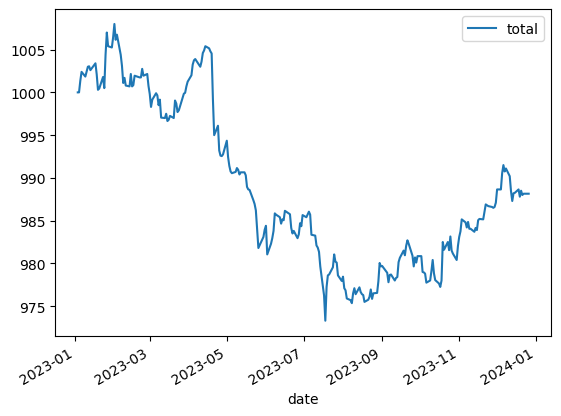

In [189]:
stock = Stock('T', df=None, initial_capital=1000, save_new=False, debug=False)
stock.addStrategy(stock.addStrategy(stock.buyStock(5)))
# stock.backtest()
stock.plotBackTest()

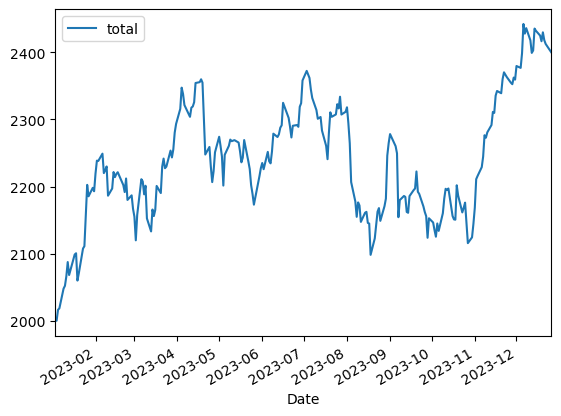

In [190]:
stock_T = Stock('T', df=None, save_new=False, debug=False)
stock_T.addStrategy(stock_T.buyStock(100))
stock_AAPL = Stock('AAPL', df=None, save_new=False, debug=False)
stock_AAPL.addStrategy(stock_AAPL.buyStock(100))

portfolio_instance = Portfolio()
portfolio_instance.addStock(stock_T)
portfolio_instance.addStock(stock_AAPL)

portfolio_instance.backtest()
portfolio_instance.plotBacktest()
# portfolio_instance.backtest_df

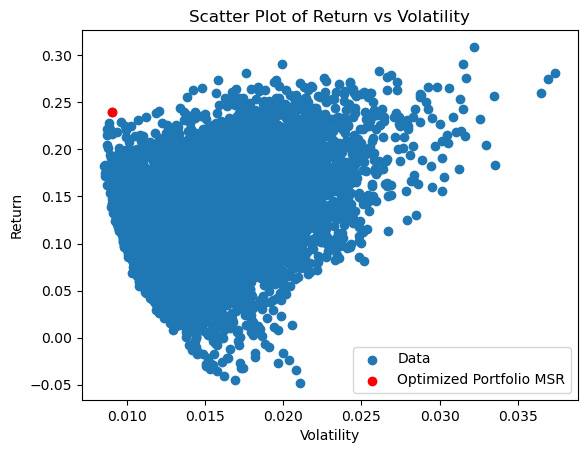

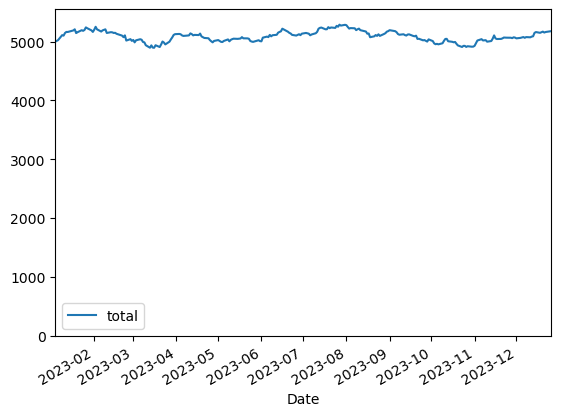

RETURNS STATS
{'vol': 0.005137587589053457, 'vol_annual': 0.08155667459668411, 'mean_daily_return': 0.00015647593867895216, 'mean_annual_return': 0.04021648671544442, 'skewness': -0.03746576882184208, 'excess_kurtosis': 0.28023343563838354, 'shapiro': ShapiroResult(statistic=0.9960334897041321, pvalue=0.7901206016540527)}
FF STATS
{'adjusted_r_squared': 0.9014095690894739, 'HML p value': 0.000659752860421227, 'SMB p value': 0.00326680020691169, 'RMW p value': 0.6456638246486862, 'CMA p value': 0.006285327809884614, 'HML': -0.021428783607957747, 'SMB': 0.014736665747399786, 'RMW': -0.0018683167276337459, 'CMA': 0.019379457811815628, 'Alpha': -0.3830315959466733, 'Annual Alpha': '-0.996958', 'ann_alpha': -0.9969580288969998, 'Beta': 0.0015503172009258197}
SMB is statistically significant.
HML is statistically significant.
CMA is statistically significant.


,T_total,T_position,BABA_total,BABA_position,GME_total,GME_position,CGW_total,CGW_position,VTI_total,VTI_position,total,total_returns,cum_daily_return
Date,,,,,,,,,,,,,
2023-01-05,1000.50,1.86,1015.02,5.89,999.24,4.01,998.66,14.91,998.49,5.22,5011.91,0.002382,0.002382
2023-01-06,1000.89,1.86,1030.99,5.89,994.99,4.01,1000.15,14.91,997.96,5.22,5024.98,0.002608,0.004996
2023-01-09,1000.69,1.86,1077.41,5.89,997.60,4.01,1014.61,14.91,1020.63,5.22,5110.94,0.017107,0.022188
2023-01-10,1000.89,1.86,1083.19,5.89,996.20,4.01,1011.18,14.91,1011.17,5.22,5102.63,-0.001626,0.020526
2023-01-11,1001.12,1.86,1092.79,5.89,1003.76,4.01,1022.81,14.91,1026.32,5.22,5146.80,0.008656,0.029360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19,995.46,1.86,855.95,5.89,1002.56,4.01,1070.37,14.91,1236.07,5.22,5160.41,0.001945,0.032082
2023-12-20,995.72,1.86,857.01,5.89,1001.12,4.01,1075.29,14.91,1241.40,5.22,5170.54,0.001963,0.034108
2023-12-21,995.54,1.86,858.66,5.89,999.76,4.01,1073.65,14.91,1227.51,5.22,5155.12,-0.002982,0.031024


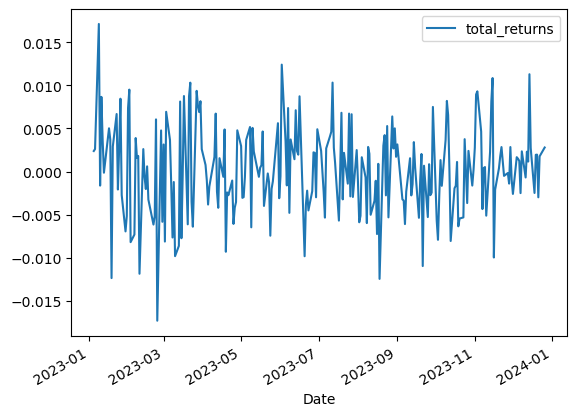

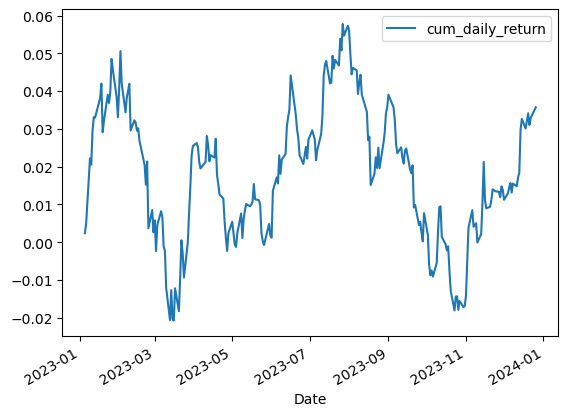

In [192]:
portfolio_instance = Portfolio()
portfolio_instance.addStock('T')
portfolio_instance.addStock('BABA')
portfolio_instance.addStock('GME')
portfolio_instance.addStock('CGW')
portfolio_instance.addStock('VTI')

markov = portfolio_instance.markowitz(weight=100, plot=True, msr=True)
# print(markov)
portfolio_instance.backtest(plot=True,stats=True)
# first_stock = portfolio_instance.stocks[0]
# df = pd.DataFrame(index=first_stock.df[next(iter(first_stock.df))].index)

In [7]:
markov[1]

{'T': 13.867344489146735,
 'BABA': 0.4092091085553919,
 'GME': 2.7479266670930196,
 'CGW': 8.720721870220832,
 'VTI': 74.25479786498403}

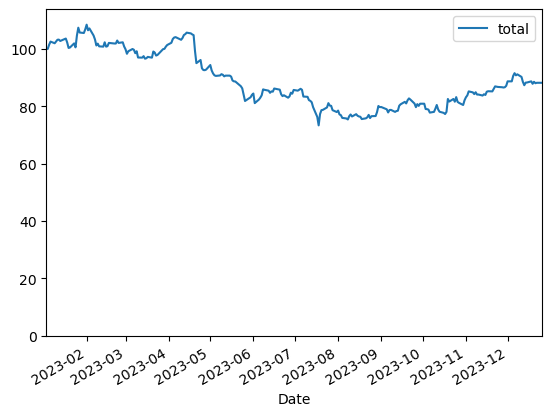

RETURNS STATS
{'vol': 0.013766427914818417, 'vol_annual': 0.21853526822584204, 'mean_daily_return': -0.0004168307888783957, 'mean_annual_return': -0.09973242754798983, 'skewness': 0.0038675438563302656, 'excess_kurtosis': 2.794798666737539, 'shapiro': ShapiroResult(statistic=0.9612122774124146, pvalue=3.3613523555686697e-06)}
FF STATS
{'adjusted_r_squared': -0.27316970699893406, 'HML p value': 0.47871559612821324, 'SMB p value': 0.7495816024864372, 'RMW p value': 0.7926206148922685, 'CMA p value': 0.9289905868174834, 'HML': -0.009087367035547406, 'SMB': 0.0039276361061171775, 'RMW': 0.00441560501460093, 'CMA': 0.0016734854286486738, 'Alpha': -0.42752388422132737, 'Annual Alpha': '-0.998761', 'ann_alpha': -0.9987609510420784, 'Beta': 0.005630034360036132}


,T_total,T_position,total,total_returns,cum_daily_return
Date,,,,,
2023-01-04,100.00,5.3,100.00,0.000000,0.0000
2023-01-05,101.43,5.3,101.43,0.014300,0.0143
2023-01-06,102.54,5.3,102.54,0.010944,0.0254
2023-01-09,101.96,5.3,101.96,-0.005656,0.0196
2023-01-10,102.54,5.3,102.54,0.005689,0.0254
...,...,...,...,...,...
2023-12-19,87.82,5.0,87.82,-0.009586,-0.1218
2023-12-20,88.52,5.0,88.52,0.007971,-0.1148
2023-12-21,88.02,5.0,88.02,-0.005648,-0.1198


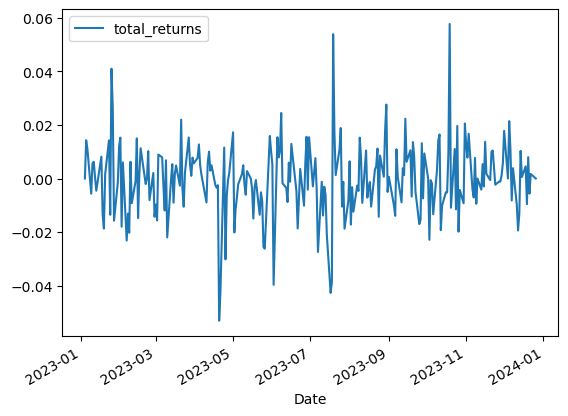

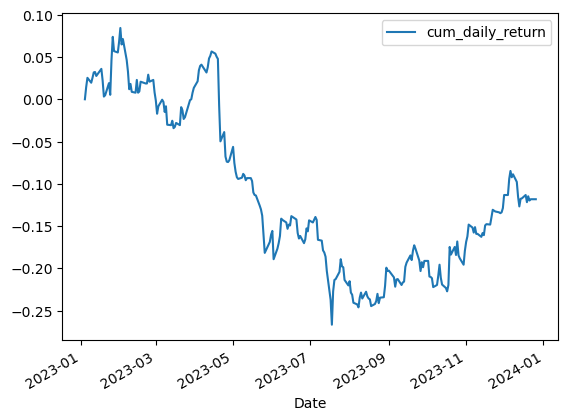

In [188]:
# FF CAPM
initial_capital = 100
ticker = 'T'

stock_instance = Stock(
    ticker, df=None, initial_capital=initial_capital, save_new=False, debug=False)
stock_instance.addStrategy(stock_instance.buyStock(10))
stock_instance.addStrategy(stock_instance.macd(1, 15))
# stock_instance.backtest()
# stock_instance.saveToCSV()
# stock_instance2 = Stock('AAPL', df=None, initial_capital=initial_capital, save_new=False, debug=False)
# stock_instance2.addStrategy(stock_instance.buyStock(10))

portfolio_instance = Portfolio()
portfolio_instance.addStock(stock_instance)
# portfolio_instance.addStock(stock_instance2)
portfolio_instance.backtest(stats=True, plot=True)


# stock_instance.viewStrategies()
# stock_instance.strategies

In [53]:
port = Portfolio()
port.equalWeightedPortfolio(['T', 'MSFT', 'AAPL'])
port.get_by_ticker('T').df